In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [19]:
data= r"H:\SP8_FLIM\Treatments\Aldometanib\Outputs\master_table.csv"
df= pd.read_csv(data)#,sep=";")

In [20]:
df

,Unnamed: 0,Label,Area,intensity_mean_fluor,mean_chi2,mean_tau,min_fluor,min_chi2,min_tau,STD_fluor,STD_chi2,STD_tau,File Name,cells,treatment,concentration,Date,selected_analysis
0,14,15,298.0,571.614094,111.714765,1007.234899,258.0,79.0,546.0,76.553631,13.367891,190.786042,NT-1,wt,Aldo,0,2024-02-07,analyze_single_fitted_channel
1,16,17,83.0,350.927711,101.433735,999.710843,283.0,73.0,521.0,22.128204,12.140932,244.122847,NT-1,wt,Aldo,0,2024-02-07,analyze_single_fitted_channel
2,17,18,61.0,479.131148,109.213115,1028.278689,457.0,84.0,694.0,10.405666,11.209064,224.694483,NT-1,wt,Aldo,0,2024-02-07,analyze_single_fitted_channel
3,18,19,53.0,480.584906,109.735849,1013.094340,455.0,77.0,585.0,11.341082,12.984971,216.987198,NT-1,wt,Aldo,0,2024-02-07,analyze_single_fitted_channel
4,19,20,34.0,498.235294,109.411765,932.411765,485.0,93.0,576.0,5.785676,9.139821,207.590536,NT-1,wt,Aldo,0,2024-02-07,analyze_single_fitted_channel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,131,132,35.0,400.514286,107.828571,1308.342857,381.0,84.0,748.0,10.597497,12.311402,292.163158,a-3,wt,Aldo,AcuteNA,2024-02-15,analyze_single_fitted_channel
1414,132,133,87.0,422.988506,107.379310,1208.505747,350.0,80.0,610.0,29.870792,11.292599,289.802266,a-3,wt,Aldo,AcuteNA,2024-02-15,analyze_single_fitted_channel
1415,133,134,133.0,361.315789,102.751880,1276.759398,223.0,71.0,704.0,53.180692,11.986462,305.875795,a-3,wt,Aldo,AcuteNA,2024-02-15,analyze_single_fitted_channel
1416,134,135,76.0,502.486842,113.921053,1360.973684,448.0,82.0,775.0,33.586688,13.758025,319.428353,a-3,wt,Aldo,AcuteNA,2024-02-15,analyze_single_fitted_channel


In [27]:
def sample_data(data, n=100):
    # Use groupby.apply with a lambda function to sample directly from each group
    sampled_df = data.groupby('concentration').apply(lambda x: x.sample(n)).reset_index(drop=True)
    
    return sampled_df

# Usage example:
sampled_data = sample_data(df)


In [32]:
def sample_data_withdate(data, n=100):
    # Group the data by concentration and date
    grouped_data = data.groupby(['concentration', 'Date'])

    # Initialize an empty DataFrame to store sampled data
    sampled_data = pd.DataFrame()

    # Iterate over each group
    for group_name, group_df in grouped_data:
        # Check the number of instances per date
        num_instances_per_date = len(group_df['Date'].unique())

        if num_instances_per_date == 1:
            # If only one instance per date, sample it directly
            sampled_group_df = group_df.sample(n=min(n, len(group_df)), replace=False)
        else:
            # Calculate the number of samples to take from each date
            samples_per_date = n // num_instances_per_date

            # Sample an equal number of instances from each date
            sampled_group_df = group_df.groupby('Date').apply(lambda x: x.sample(min(samples_per_date, len(x)), replace=False)).reset_index(drop=True)

        # Append the sampled data to the DataFrame
        sampled_data = pd.concat([sampled_data, sampled_group_df], ignore_index=True)

    return sampled_data


In [33]:
sampled_data2 = sample_data_withdate(df)

C:\Users\XXX\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\XXX\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\XXX\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\XXX\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

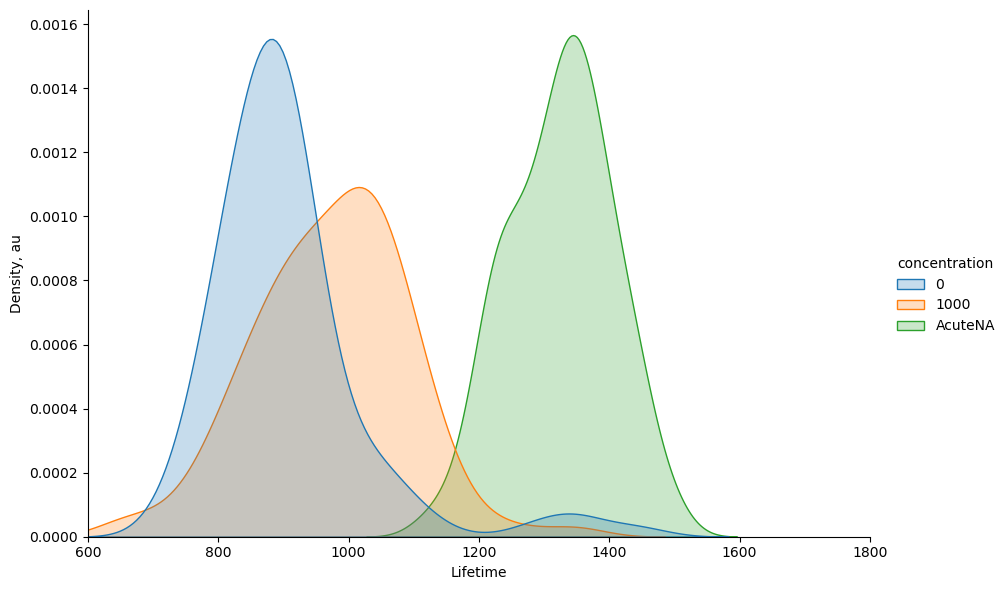

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create the plot
h = sns.displot(
    sampled_data, hue="concentration", x="mean_tau",
    kind="kde", height=6, aspect=1.5, fill=True 
)

# Set axis labels
h.set_axis_labels("Lifetime", "Density, au")

# Set the title of the plot
h.set_titles("{col_name}")

# Set x-axis limits
h.set(xlim=(600, 1800))

# Show the plot
plt.show()

In [13]:
def plot_age_all (dataset=new1,height=3.5, aspect=.7):
    sns.set_theme(style="whitegrid", palette="pastel")
    g = sns.displot(
    dataset,x="tau", hue="Time",
    kind="kde", fill=True, col_order=['4-6h','24-28h'],hue_order=['4-6h','24-28h'],
     height=height, aspect=aspect,
    )
    g.set_axis_labels("Lifetime", "Density,au")
    g.set_titles("{col_name}")
    g.set(xlim=(600,1800))
    return g

def plot_age(dataset=new1,height=4, aspect=.5):
    g = sns.displot(
    dataset,x="tau", hue="Time",col='Time',
    kind="kde", fill=True, col_order=['4-6h','24-28h'],hue_order=['4-6h','24-28h'],
     height=height, aspect=aspect,
    )
    g.set_axis_labels("Lifetime", "Density,au")
    g.set_titles("{col_name}")
    g.set(xlim=(600,1800))
    return g

def plot_conditons (dataset=new1,height=4, aspect=.5):
    h = sns.displot(
    dataset,x="tau", hue="Condition",col='Condition',
    kind="kde", fill=True,col_order=['wt','cl1','cl2'],hue_order=['wt','cl1','cl2'],
     height=4, aspect=.5,
    )
    h.set_axis_labels("Lifetime", "Density,au")
    h.set_titles("{col_name}")
    h.set(xlim=(600,1800))
    return h
def plot_conditons_all (dataset=new1,height=4, aspect=.5):
    h = sns.displot(
    dataset,x="tau", hue="Condition",
    kind="kde", fill=True,col_order=['wt','cl1','cl2'],hue_order=['wt','cl1','cl2'],
     height=height, aspect=aspect,
    )
    h.set_axis_labels("Lifetime", "Density,au")
    h.set_titles("{col_name}")
    h.set(xlim=(600,1800))
    return h


def plot_swarm_cond (dataset=new1,sorting='Condition',kind=None
                     ):
    
    sns.set_theme(style="whitegrid", palette="pastel")
    if kind=='wt_vs_2clones':
        g = sns.catplot(
        new1,y="tau",hue=sorting,x=sorting,col_order=['wt','cl1','cl2'],hue_order=['wt','cl1','cl2'],
        kind="swarm"
        )
    else:
        g = sns.catplot(
        new1,y="tau",hue=sorting,x=sorting,
        kind="swarm"
        )
        
    g.set_axis_labels("Condition", "Lifetime,ps")
    g.set_titles("{col_name}")
    g.set(ylim=(500,1600))
    return  g
#height=4, aspect=.7,, height=height, aspect=aspect, 
 
def plot_swarm_age (dataset,height=3.5, aspect=.7,):
    sns.set_theme(style="whitegrid", palette="pastel")
    h = sns.catplot(
    dataset,y="tau",hue="Time",col="Time",col_order=['4-6h','24-28h'],hue_order=['4-6h','24-28h'],
    kind="swarm", height=height, aspect=aspect, 
    )
    h.set_axis_labels("Condition", "Lifetime,ps")
    h.set_titles("{col_name}")
    h.set(ylim=(500,1600))
    return  h



Here end 